In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss

In [3]:
def compute_scores(y_true, y_pred_proba, name=None):
    scores = {
        'brier_score'     : brier_score_loss(y_true, y_pred_proba),
        'log_loss_score'  : log_loss(y_true, y_pred_proba),
        'roc_acu'         : roc_auc_score(y_true, y_pred_proba)
    }
    
    return pd.Series(scores).rename(name)

```plaintext
The Brier score is more like a cost function, Lower value implies accurate prediction

Formula - BS= 
 
    N
1/N ∑ (yi - p)^2
   i=1

yi - True label (0,1) 
p - predicted value 
```

If we predict an even occurs at 100 prob and the even occures then (1-1) = 0 best case 
If we predict an even occurs at 100 prob and the even does not occur then (0-1) = 1 worst case 

See the below diagram to understand

How is it different from MSE ---

weather pred system - 
1) Rainfall prob         ( Classification )
2) Amount of rainfall    ( Regression )

### **Brier Score: Predicted Rainfall Probability**

| **Day** | **Predicted Probability (p)** | **Actual (y)** | **Error (y - p)^2** |
|---------|--------------------------------|----------------|---------------------|
| Day 1   | 0.7                            | 1              |  (1 - 0.7)^2 = 0.09  |
| Day 2   | 0.2                            | 0              |  (0 - 0.2)^2 = 0.04  |

BS = 1/2 [ 0.09 + 0.04 ] = 0.0467 (approx)

The true value is binary (0 or 1), reflecting class membership.

Use when evaluating the accuracy of probability predictions.


True value is continuous, representing a measurable quantity.

### **MSE: Predicted Amount of Rainfall**

| **Day** | **Predicted (p)** | **Actual (y)** | **Error (y - p)^2** |
|---------|--------------------|----------------|---------------------|
| Day 1   | 10 mm              | 12 mm          |  (12 - 10)^2 = 4  |
| Day 2   | 1 mm               | 0 mm           |  (0 - 1)^2 = 1  |

MSE = 1/2[ 4 + 1 ] = 2.5

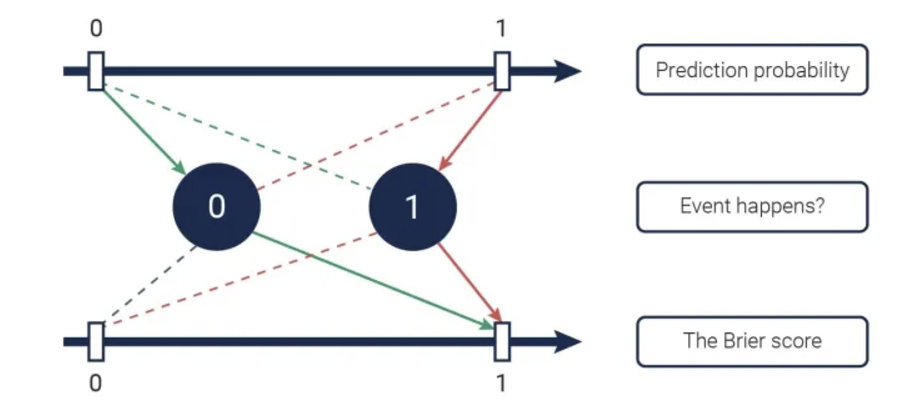

Creating a sample dataset for out binary classification task

In [4]:
x,y = make_classification(
    n_samples=10000,              # total number of rows 
    n_classes=2,               # creates a binary classification 
    weights=[0.7,0.3],         # defining the proportion of each class 
    random_state=42
)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)

Training the SVM (We are not performing any fine tuning for calibration)

```plaintext

y_pred_prob = clf.decision_function(x_test) -> distance of each sample in the input data from the separating hyperplane. This distance is known as the decision score

+ve score indicates the sample is on the positive side

-ve score indicates the sample is on the negative side

Magnitude of the score indicates the confidence of the classification.

In [6]:
clf = SVC(kernel='rbf', random_state=42)
clf.fit(x_train,y_train)

y_pred_prob = clf.decision_function(x_test) 
y_pred_prob = ((y_pred_prob - y_pred_prob.min())/(y_pred_prob.max() - y_pred_prob.min()))

## Calibration Curve Explanation

### **Straight Line (Diagonal)**
- **Perfect Calibration**: If the model predicts 60% chance of rain, it rains 60% of the time.

### **Curve Line**
- **Below the Diagonal (Overconfident)**: The model predicts 60%, but it rains only 40% of the time.
- **Above the Diagonal (Underconfident)**: The model predicts 60%, but it rains 80% of the time.

### **How the Calibrated Curve is Generated**
- **Predicted Probabilities (`y_pred_prob`)**:  
  `[0.05, 0.07, 0.1, 0.12, 0.14, 0.18, 0.2, 0.25, 0.28, 0.3, 0.33, 0.36, 0.4, 0.42, 0.45, 0.48, 0.51, 0.54, 0.57, 0.6, 0.63, 0.65, 0.68, 0.7, 0.72, 0.75, 0.78, 0.8, 0.83, 0.85]`

- **True Labels (`y_test`)**:  
  `[0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0]`

### **Bin Calculations**

| **Bin Range** | **Predicted Probabilities**        | **True Labels**  | **`prob_pred` (X-axis)**         | **`prob_true` (Y-axis)**       |
|---------------|-------------------------------------|------------------|----------------------------------|--------------------------------|
| `[0.0-0.1]`   | `[0.05, 0.07]`                     | `[0, 0]`         | Mean: `0.06`                    | Sum: `0/2` → `0.0`             |
| `[0.1-0.2]`   | `[0.1, 0.12, 0.14]`                | `[0, 1, 0]`      | Mean: `0.12`                    | Sum: `1/3` → `0.33`            |
| `[0.2-0.3]`   | `[0.18, 0.2, 0.25, 0.28]`          | `[1, 0, 1, 0]`   | Mean: `0.2275`                  | Sum: `2/4` → `0.5`             |
| `[0.3-0.4]`   | `[0.3, 0.33, 0.36, 0.4]`           | `[1, 0, 1, 0]`   | Mean: `0.3375`                  | Sum: `2/4` → `0.5`             |
| `[0.4-0.5]`   | `[0.42, 0.45, 0.48]`               | `[1, 0, 1]`      | Mean: `0.45`                    | Sum: `2/3` → `0.67`            |
| `[0.5-0.6]`   | `[0.51, 0.54, 0.57]`               | `[1, 0, 1]`      | Mean: `0.54`                    | Sum: `2/3` → `0.67`            |
| `[0.6-0.7]`   | `[0.6, 0.63, 0.65]`                | `[1, 0, 1]`      | Mean: `0.6267`                  | Sum: `2/3` → `0.67`            |
| `[0.7-0.8]`   | `[0.68, 0.7, 0.72]`                | `[1, 0, 1]`      | Mean: `0.7`                     | Sum: `2/3` → `0.67`            |
| `[0.8-0.9]`   | `[0.75, 0.78, 0.8]`                | `[1, 1, 1]`      | Mean: `0.7767`                  | Sum: `3/3` → `1.0`             |
| `[0.9-1.0]`   | `[0.83, 0.85]`                     | `[1, 0]`         | Mean: `0.84`                    | Sum: `1/2` → `0.5`             |

### **Summary**
- **X-axis**: Predicted probabilities (mean of values in each bin).
- **Y-axis**: True probabilities (fraction of positives in each bin).
- **Calibration Curve**: Shows how well the predicted probabilities match the actual outcomes.


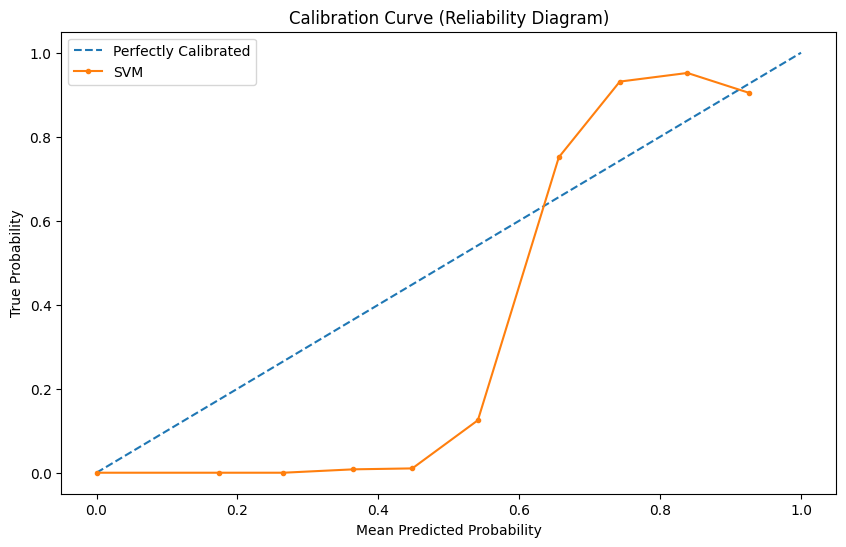

In [7]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)
plt.figure(figsize=(10,6))
plt.plot([0,1], [0,1], linestyle='--', label='Perfectly Calibrated')
plt.plot(prob_pred, prob_true, marker='.', label='SVM')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend()
plt.show()

# Platt Scaling for Probability Calibration

**Platt Scaling** is a *post-processing technique* for probability calibration, widely used in binary classification tasks.

It fits a **logistic regression model** to the scores predicted by a classifier.

#### Platt Scaling Formula
**s(x)** = $\frac{1}{1+exp(-(Ax+B))}$

- **s(x)**: The calibrated probability
- **x**: The *raw scores or logits* output of the model (before applying softmax or any activation).
- **A and B**: Coefficients learned by fitting the logistic regression model to the **calibration dataset**.
  - **A**: How *sharply* - sigmoid curve (steepness).
  - **B**: Controls *horizontal shift* of sigmoid curve.


#### Steps for Platt Scaling

1. **Train the model** and get predicted outputs (raw scores).
2. Use a portion of **training dataset** as the **calibration dataset**.
   - The calibration dataset contains raw scores (\(x\)) and their corresponding **true labels** (\(y\)).
3. Fit a **logistic regression model** to the calibration dataset to learn the values of **A** and **B**.
4. Use the learned parameters to map raw scores (\(x\)) to **calibrated probabilities** (\(s(x)\)).

## Purpose of \( s(x) \)

- \( s(x) \) is **calibrating the likelihood** that an instance belongs to the **positive (+ve) class**.
- It acts like a **logistic regression model**, mapping raw scores to probabilities between **0 and 1**.
- The calibrated probability \( s(x) \) is **more trustworthy** than raw scores for decision-making.
- Probabilities:
  - **High (\(s(x) > 0.5\))**: Favor predicting the **positive class**.
  - **Low (\(s(x) < 0.5\))**: Favor predicting the **negative class**.


### Example Interpretation

| **Raw Score (x)** | **True Label (y)** | **Calibrated Probability s(x)** |
|--------------------|--------------------|-----------------------------------------|
| 1.5               | 1                  | 0.9503                                  |
| 0.5               | 1                  | 0.6106                                  |
| -1.0              | 0                  | 0.0356                                  |
| -1.5              | 0                  | 0.0105                                  |
| 2.0               | 1                  | 0.9852                                  |
| -0.5              | 0                  | 0.1141                                  |
| 0.0               | 1                  | 0.3100                                  |

#### Explanation:
- For **raw score = 1.5**, \( s(x) = 0.9503 \):  
  The model predicts a **95.03% chance** that the instance belongs to the **positive class**.
- For **raw score = -1.0**, \( s(x) = 0.0356 \):  
  The model predicts only a **3.56% chance** that the instance belongs to the **positive class**.


## Visualization

The following graph helps understand the effect of **A** and **B**:

- **A (Steepness)**:
  - Larger \( A \): Makes the sigmoid curve *steeper* (sharper transitions between probabilities).
  - Smaller \( A \): Flattens the sigmoid curve (less decisive transitions).
- **B (Shift)**:
  - Positive \( B \): Shifts the curve **right**.
  - Negative \( B \): Shifts the curve **left**.

This ensures raw scores are transformed into reliable, calibrated probabilities for better decision-making.

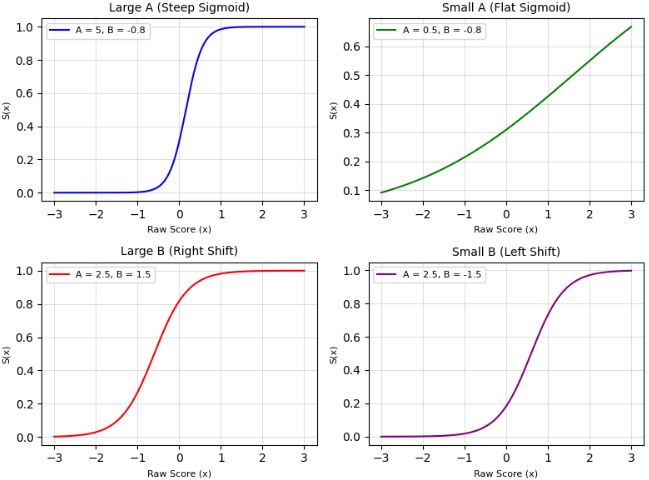

## Isotonic Regression 

calibrate predictions while ensuring they follow a monotonic (non-decreasing), monotonic trend in isotonic regression is done because reasonable to expect that higher predicted values should correspond to higher actual probabilities or outcomes.


In [11]:
# Calibration using Platt Scaling 
clf_plat = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
clf_plat.fit(x_train, y_train)

# Calibrate using Isotonic Regression 
clf_isotonic = CalibratedClassifierCV(clf, cv=5, method='isotonic')
clf_isotonic.fit(x_train, y_train)

CalibratedClassifierCV(cv=5, estimator=SVC(random_state=42), method='isotonic')

In [12]:
y_pred_prob_platt = clf_plat.predict_proba(x_test)[:,1]
y_pred_prob_isotonic = clf_isotonic.predict_proba(x_test)[:,1]

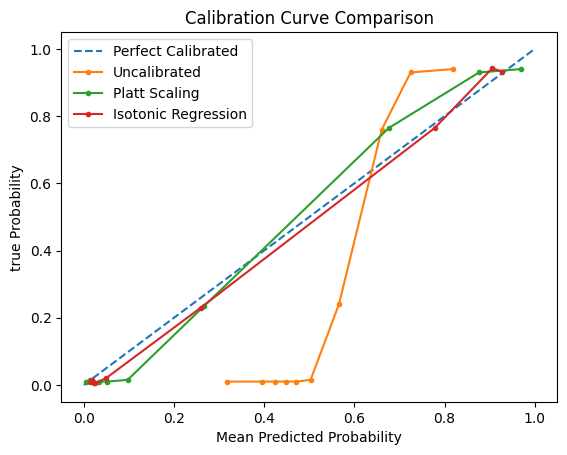

In [15]:
# Calculating the calibrated_curve 
prob_true, prob_pred_uncal = calibration_curve(y_test, y_pred_prob, n_bins=10, strategy='quantile')
prob_true_platt, prob_pred_platt = calibration_curve(y_test, y_pred_prob_platt, n_bins=10, strategy='quantile')
prob_true_isotonic, prob_pred_isotonic = calibration_curve(y_test, y_pred_prob_isotonic, n_bins=10, strategy='quantile')

# Calibrated Plots 
plt.plot([0,1],[0,1], linestyle='--', label='Perfect Calibrated')
plt.plot(prob_pred_uncal, prob_true, marker='.', label='Uncalibrated')
plt.plot(prob_pred_platt,prob_true_platt, marker='.', label='Platt Scaling')
plt.plot(prob_pred_isotonic, prob_true_isotonic, marker='.', label = 'Isotonic Regression')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("true Probability")
plt.title("Calibration Curve Comparison")
plt.legend()
plt.show()

In [18]:
df_scores = pd.DataFrame([
    compute_scores(y_test, y_pred_prob, name='Uncalibrated'),
    compute_scores(y_test, y_pred_prob_platt, name='Platt Scaling'),
    compute_scores(y_test, y_pred_prob_isotonic, name='Isotonic Regression')
])
df_scores

,brier_score,log_loss_score,roc_acu
Uncalibrated,0.177542,0.539588,0.968339
Platt Scaling,0.053869,0.202653,0.968106
Isotonic Regression,0.051877,0.188629,0.967950
